In [1]:
import numpy as np
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
import os
from utils import *
import matplotlib.pyplot as plt
import seaborn
import plotly.express as px
import boto3
import sagemaker
from sagemaker import get_execution_role
from sagemaker.serializers import IdentitySerializer
from sklearn.metrics import mean_absolute_error

# Exploratory Data Analysis

In [2]:
# source: https://github.com/owid/co2-data
df = pd.read_csv('https://raw.githubusercontent.com/owid/co2-data/master/owid-co2-data.csv')
df

,iso_code,country,year,co2,co2_growth_prct,co2_growth_abs,consumption_co2,trade_co2,trade_co2_share,co2_per_capita,...,ghg_per_capita,methane,methane_per_capita,nitrous_oxide,nitrous_oxide_per_capita,primary_energy_consumption,energy_per_capita,energy_per_gdp,population,gdp
0,AFG,Afghanistan,1949,0.015,NaN,NaN,NaN,NaN,NaN,0.002,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7663783.0,NaN
1,AFG,Afghanistan,1950,0.084,475.000,0.070,NaN,NaN,NaN,0.011,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7752000.0,1.949480e+10
2,AFG,Afghanistan,1951,0.092,8.696,0.007,NaN,NaN,NaN,0.012,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7840000.0,2.006385e+10
3,AFG,Afghanistan,1952,0.092,NaN,NaN,NaN,NaN,NaN,0.012,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7936000.0,2.074235e+10
4,AFG,Afghanistan,1953,0.106,16.000,0.015,NaN,NaN,NaN,0.013,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8040000.0,2.201546e+10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23703,ZWE,Zimbabwe,2015,12.170,1.653,0.198,13.308,1.138,9.350,0.881,...,4.885,11.87,0.859,6.68,0.484,NaN,NaN,NaN,13815000.0,2.503057e+10
23704,ZWE,Zimbabwe,2016,10.815,-11.139,-1.356,12.171,1.356,12.542,0.771,...,4.703,11.92,0.850,6.55,0.467,NaN,NaN,NaN,14030000.0,2.515176e+10
23705,ZWE,Zimbabwe,2017,10.247,-5.251,-0.568,11.774,1.527,14.902,0.720,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14237000.0,NaN
23706,ZWE,Zimbabwe,2018,11.341,10.674,1.094,12.815,1.475,13.006,0.785,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14439000.0,NaN


In [3]:
# data info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23708 entries, 0 to 23707
Data columns (total 55 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   iso_code                             20930 non-null  object 
 1   country                              23708 non-null  object 
 2   year                                 23708 non-null  int64  
 3   co2                                  23170 non-null  float64
 4   co2_growth_prct                      21910 non-null  float64
 5   co2_growth_abs                       22017 non-null  float64
 6   consumption_co2                      3350 non-null   float64
 7   trade_co2                            3318 non-null   float64
 8   trade_co2_share                      3318 non-null   float64
 9   co2_per_capita                       22383 non-null  float64
 10  consumption_co2_per_capita           3350 non-null   float64
 11  share_global_co2            

In [4]:
# group co2 feature by year
ts = df[['year', 'co2']].groupby('year').sum()
ts.index = pd.date_range(start=pd.datetime(ts.index.min(), 1, 1), periods=270, freq='A')
ts

/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages/ipykernel/__main__.py:3: FutureWarning:

The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.



,co2
1750-12-31,46.755
1751-12-31,46.755
1752-12-31,46.770
1753-12-31,46.770
1754-12-31,46.790
...,...
2015-12-31,123813.289
2016-12-31,123890.716
2017-12-31,125438.734
2018-12-31,127746.944


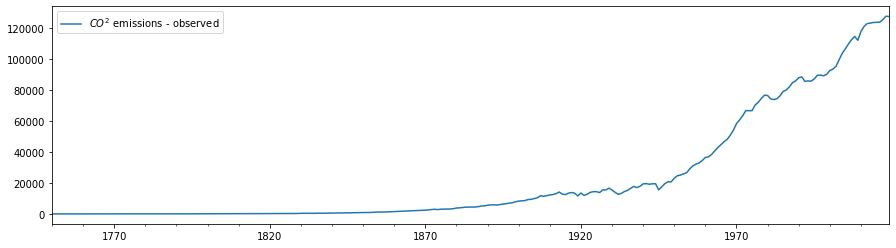

In [5]:
# decompose time series in observed, seasonal, trend and residuals
result = seasonal_decompose(ts.co2, model='multiplicative')

plt.figure(figsize=(15,4))
result.observed.plot(label='$CO^{2}$ emissions - observed')
plt.legend()
plt.savefig('img/ts_observed.png')
plt.show()

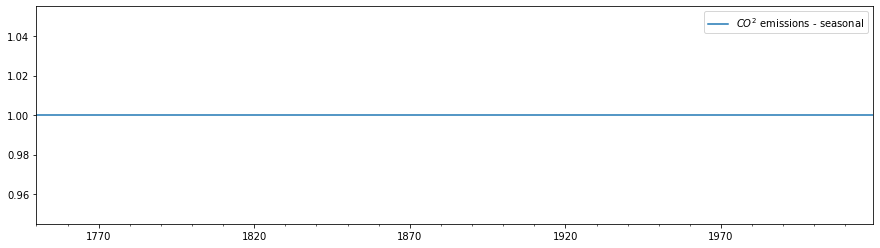

In [6]:
plt.figure(figsize=(15,4))
result.seasonal.plot(label='$CO^{2}$ emissions - seasonal')
plt.legend()
plt.savefig('img/ts_seasonal.png')
plt.show()

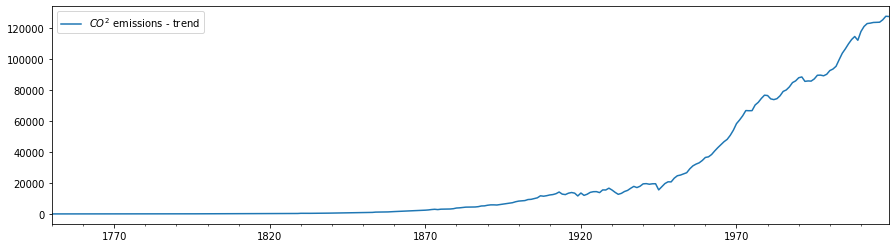

In [7]:
plt.figure(figsize=(15,4))
result.trend.plot(label='$CO^{2}$ emissions - trend')
plt.legend()
plt.savefig('img/ts_trend.png')
plt.show()

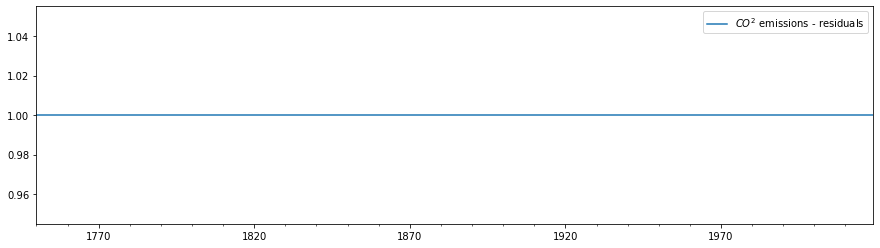

In [8]:
plt.figure(figsize=(15,4))
result.resid.plot(label='$CO^{2}$ emissions - residuals')
plt.legend()
plt.savefig('img/ts_residuals.png')
plt.show()

Running the plots of the observed, trend, seasonal, and residual time series, we can see that the results doesn't interesting. So let's try another approach to extract some insights about the time series. Next, the amount of carbon dioxide emission will be analyzed every 50 years, since 1850.

In [9]:
ts50 = ts['1850':].reset_index().rename(columns={'index':'timestamp'})

def classify_period(x):
    if x.year >= 1850 and x.year <= 1900:
        return '1850 to 1900'
    if x.year > 1900 and x.year <= 1950:
        return '1900 to 1950'
    if x.year > 1950 and x.year <= 2000:
        return '1950 to 2000'
    if x.year > 2000:
        return '> 2000'
    
ts50['period'] = ts50['timestamp'].apply(classify_period)
ts50

,timestamp,co2,period
0,1850-12-31,944.824,1850 to 1900
1,1851-12-31,944.689,1850 to 1900
2,1852-12-31,984.086,1850 to 1900
3,1853-12-31,1025.620,1850 to 1900
4,1854-12-31,1209.253,1850 to 1900
...,...,...,...
165,2015-12-31,123813.289,> 2000
166,2016-12-31,123890.716,> 2000
167,2017-12-31,125438.734,> 2000
168,2018-12-31,127746.944,> 2000


/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



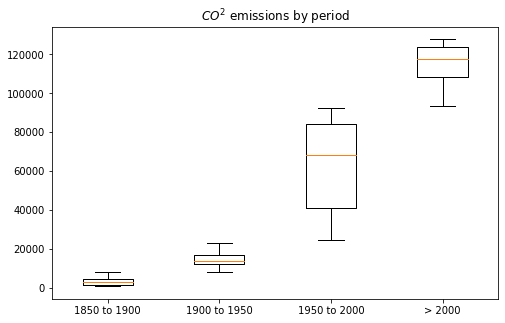

In [10]:
# source: https://stackoverflow.com/questions/52273543/creating-multiple-boxplots-on-the-same-graph-from-a-dictionary/52274064
d = {
    '1850 to 1900': list(ts50[ts50.period == '1850 to 1900'].co2.values),
    '1900 to 1950': list(ts50[ts50.period == '1900 to 1950'].co2.values),
    '1950 to 2000': list(ts50[ts50.period == '1950 to 2000'].co2.values),
    '> 2000': list(ts50[ts50.period == '> 2000'].co2.values),
}

fig, ax = plt.subplots(figsize=(8,5))
ax.boxplot(d.values())
ax.set_xticklabels(d.keys())
plt.title('$CO^{2}$ emissions by period')
plt.savefig('img/emissions_by_period.png')
plt.show()

In [11]:
grouped = ts50.groupby('period').mean()
grouped['percetual_change'] = round((grouped.co2 - grouped.iloc[0].co2) / grouped.iloc[0].co2 * 100, 2)
grouped

,co2,percetual_change
period,,
1850 to 1900,3511.905941,0.00
1900 to 1950,14672.126920,317.78
1950 to 2000,62801.521540,1688.25
> 2000,115070.215526,3176.57


In the boxplot it is possible to observe the variation in the quartiles of carbon dioxide emission in the periods from 1850 to 1900, 1900 to 1950, 1950 to 2000, and 2000 to 2019. The annual averages of global carbon dioxide emissions in the period from 1950 to 2000 increased by 1,688% compared to the period from 1850 to 1900, and in the period from 2000 to 2019 emissions increased by 3,176%.

Another interesting approach could be check the percentual variation year by year. 

In [12]:
tsbar = ts['1850':]
tsbar['percetual_change'] = tsbar.pct_change() * 100
tsbar

/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,co2,percetual_change
1850-12-31,944.824,NaN
1851-12-31,944.689,-0.014288
1852-12-31,984.086,4.170367
1853-12-31,1025.620,4.220566
1854-12-31,1209.253,17.904585
...,...,...
2015-12-31,123813.289,0.066294
2016-12-31,123890.716,0.062535
2017-12-31,125438.734,1.249503
2018-12-31,127746.944,1.840109


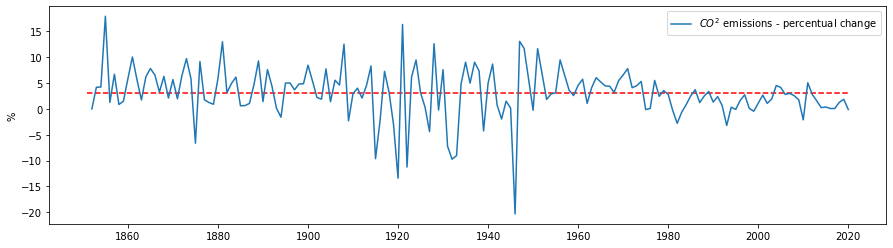

In [44]:
plt.figure(figsize=(15,4))
plt.plot(tsbar.percetual_change, label='$CO^{2}$ emissions - percentual change')
plt.hlines(tsbar.percetual_change.mean(), ls='--', color='red', xmin=tsbar.index.min(), xmax=tsbar.index.max())
plt.ylabel('%')
plt.legend()
plt.savefig('img/emissions_percentual_change.png')
plt.show()

In [14]:
tsbar.percetual_change.describe()

count    169.000000
mean       3.066116
std        4.923850
min      -20.324288
25%        0.835550
50%        3.084643
75%        5.701284
max       17.904585
Name: percetual_change, dtype: float64

We can conclude so far that, on average, the percentage change from year to year is approximately 3%.

# Data Preprocessing

In [15]:
time_series = make_time_series(ts.co2)
time_series[0]

1750-12-31       46.755
1751-12-31       46.755
1752-12-31       46.770
1753-12-31       46.770
1754-12-31       46.790
                ...    
1995-12-31    87252.937
1996-12-31    89621.706
1997-12-31    89708.397
1998-12-31    89286.496
1999-12-31    90256.260
Freq: A-DEC, Name: co2, Length: 250, dtype: float64

In [16]:
time_series_training = create_training_series(time_series, 5)
time_series_training[0]

1750-12-31       46.755
1751-12-31       46.755
1752-12-31       46.770
1753-12-31       46.770
1754-12-31       46.790
                ...    
1990-12-31    88010.112
1991-12-31    88534.589
1992-12-31    85683.429
1993-12-31    85945.146
1994-12-31    85845.104
Freq: A-DEC, Name: co2, Length: 245, dtype: float64

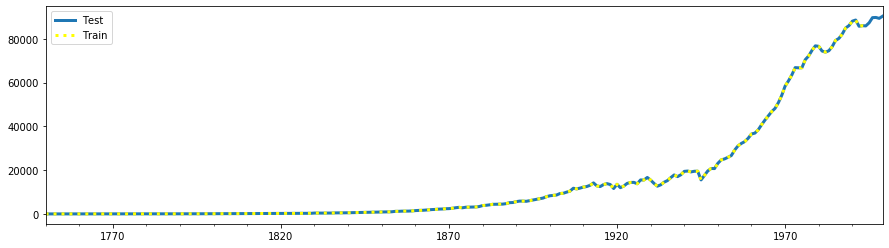

In [17]:
# display train/test time series
time_series_idx = 0

plt.figure(figsize=(15,4))
time_series[time_series_idx].plot(label='Test', lw=3) # test data is the whole time series
time_series_training[time_series_idx].plot(label='Train', ls=':', lw=3, color='yellow') # train data is all but the last prediction pts
plt.legend()
plt.savefig('img/example_train_test.png')
plt.show()

In [18]:
# save data to a local directory
data_dir = 'json_data'

# make data dir, if it does not exist
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

In [19]:
# directories to save train/test data
train_key = os.path.join(data_dir, 'train.json')
test_key = os.path.join(data_dir, 'test.json')

# write train/test JSON files
write_json_dataset(time_series_training, train_key)        
write_json_dataset(time_series, test_key)

json_data/train.json saved.
json_data/test.json saved.


# Uploading data to S3

In [20]:
# session, role, bucket
sagemaker_session = sagemaker.Session()
role = get_execution_role()
bucket = sagemaker_session.default_bucket()

# general prefix
prefix = 'co2-emission'

# *unique* train/test prefixes
train_prefix = '{}/{}'.format(prefix, 'train')
test_prefix = '{}/{}'.format(prefix, 'test')

# uploading data to S3, and saving locations
train_path = sagemaker_session.upload_data(train_key, bucket=bucket, key_prefix=train_prefix)
test_path = sagemaker_session.upload_data(test_key,  bucket=bucket, key_prefix=test_prefix)

# check locations
print('Training data is stored in: '+ train_path)
print('Test data is stored in: '+ test_path)

Training data is stored in: s3://sagemaker-sa-east-1-072590943848/co2-emission/train/train.json
Test data is stored in: s3://sagemaker-sa-east-1-072590943848/co2-emission/test/test.json


# Training a DeepAR Estimator

In [21]:
region = sagemaker_session.boto_region_name
region

'sa-east-1'

In [22]:
image_name = sagemaker.amazon.amazon_estimator.get_image_uri(region, 'forecasting-deepar', 'latest')
image_name

The method get_image_uri has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: latest.


'855470959533.dkr.ecr.sa-east-1.amazonaws.com/forecasting-deepar:1'

In [23]:
# dir to save model artifacts
s3_output_path = "s3://{}/{}/output".format(bucket, prefix)
s3_output_path

's3://sagemaker-sa-east-1-072590943848/co2-emission/output'

In [24]:
estimator = sagemaker.estimator.Estimator(
    image_uri=image_name,
    sagemaker_session=sagemaker_session,
    role=role,
    train_instance_count=1,
    train_instance_type='ml.c4.2xlarge',
    base_job_name='deepar-co2-emission',
    output_path=s3_output_path
)

freq = '12M'

hyperparameters = {
    'time_freq': freq,
    'epochs': '400',
    'early_stopping_patience': '40',
    'mini_batch_size': '64',
    'learning_rate': '5E-4',
    'context_length': '5',
    'prediction_length': '5'
}

train_instance_count has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [25]:
estimator.set_hyperparameters(**hyperparameters)

In [26]:
%%time

data_channels = {
    "train": train_path,
    "test": test_path
}

estimator.fit(inputs=data_channels, wait=True)

2021-02-23 02:42:36 Starting - Starting the training job...
2021-02-23 02:43:00 Starting - Launching requested ML instancesProfilerReport-1614048156: InProgress
.........
2021-02-23 02:44:22 Starting - Preparing the instances for training...
2021-02-23 02:45:02 Downloading - Downloading input data...
2021-02-23 02:45:37 Training - Training image download completed. Training in progress..Arguments: train
[02/23/2021 02:45:39 INFO 140240734582592] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'num_dynamic_feat': u'auto', u'dropout_rate': u'0.10', u'mini_batch_size': u'128', u'test_quantiles': u'[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'num_eval_samples': u'100', u'learning_rate': u'0.001', u'num_cells': u'40', u'num_layers': u'2', u'embedding_dimension': u'10', u'_kvstore': u'auto', u'_num_kv_servers': u'auto', u'cardinality': u'auto', u'likelihood': u's

In [27]:
# source: https://github.com/aws/amazon-sagemaker-examples/blob/master/introduction_to_amazon_algorithms/deepar_electricity/DeepAR-Electricity.ipynb
class DeepARPredictor(sagemaker.predictor.Predictor):
    
    def __init__(self, *args, **kwargs):
        super().__init__(
            *args,              
            serializer=IdentitySerializer(content_type='application/json'),
            **kwargs
        )
        
    def predict(self, ts, cat=None, dynamic_feat=None, num_samples=100, return_samples=False, quantiles=['0.1', '0.5', '0.9']):
        '''Requests the prediction of for the time series listed in `ts`, each with the (optional)
        corresponding category listed in `cat`.
        
        Parameters
        ----------
        ts (pandas.Series object) : The time series to predict
        cat (int) : The group associated to the time series (default: None)
        num_samples (int) : number of samples to compute at prediction time (default: 100)
        return_samples : boolean indicating whether to include samples in the response (default: False)
        quantiles : list of strings specifying the quantiles to compute (default: ["0.1", "0.5", "0.9"])
        
        Returns
        -------
        List of `pandas.DataFrame` objects, each containing the predictions.
        '''
        
        prediction_time = ts.index[-1] + ts.index.freq
        quantiles = [str(q) for q in quantiles]
        req = self.__encode_request(ts, cat, dynamic_feat, num_samples, return_samples, quantiles)
        res = super(DeepARPredictor, self).predict(req)
        return self.__decode_response(res, ts.index.freq, prediction_time, return_samples)
    
    def __encode_request(self, ts, cat, dynamic_feat, num_samples, return_samples, quantiles):
        instance = series_to_dict(ts, cat if cat is not None else None, dynamic_feat if dynamic_feat else None)
        
        configuration = {
            "num_samples": num_samples,
            "output_types": ["quantiles", "samples"] if return_samples else ["quantiles"],
            "quantiles": quantiles
        }
        
        http_request_data = {
            "instances": [instance],
            "configuration": configuration
        }
        
        return json.dumps(http_request_data).encode('utf-8')
    
    def __decode_response(self, response, freq, prediction_time, return_samples):
        # we only sent one time series so we only receive one in return
        # however, if possible one will pass multiple time series as predictions will then be faster
        predictions = json.loads(response.decode('utf-8'))['predictions'][0]
        prediction_length = len(next(iter(predictions['quantiles'].values())))
        prediction_index = pd.date_range(start=prediction_time, freq=freq, periods=prediction_length)
        if return_samples:
            dict_of_samples = {'sample_' + str(i): s for i, s in enumerate(predictions['samples'])}
        else:
            dict_of_samples = {}
        return pd.DataFrame(data={**predictions['quantiles'], **dict_of_samples}, index=prediction_index)

    def set_frequency(self, freq):
        self.freq = freq
        
def encode_target(ts):
    return [x if np.isfinite(x) else "NaN" for x in ts]        

def series_to_dict(ts, cat=None, dynamic_feat=None):
    '''Given a pandas.Series object, returns a dictionary encoding the time series.

    Paramenters
    -----------
    ts : a pands.Series object with the target time series
    cat : an integer indicating the time series category

    Returns
    -------
    A dictionary
    '''
    
    obj = {"start": str(ts.index[0]), "target": encode_target(ts)}
    if cat is not None:
        obj["cat"] = cat
    if dynamic_feat is not None:
        obj["dynamic_feat"] = dynamic_feat        
    return obj

# Evaluating the model

The method that can be used for cross-validating the time-series model is cross-validation on a rolling basis, or *Time Series Split Cross-Validation*. Start with a small subset of data for training purpose, forecast for the later data points and then checking the accuracy for the forecasted data points. The same forecasted data points are then included as part of the next training dataset and subsequent data points are forecasted. What we need to do is to create 4 pairs of training/test sets that follow those two rules:

* every test set contains unique observations
* observations from the training set occur before their corresponding test set 

Source: https://medium.com/@soumyachess1496/cross-validation-in-time-series-566ae4981ce4.

<img src='img/time-series-cross-validation.png'>

The evaluation metric choosed for this project is the mean absolute percentage error (MAPE), is a measure of prediction accuracy of a forecasting method in statistics, for example in trend estimation, also used as a loss function for regression problems in machine learning. It usually expresses the accuracy as a ratio defined by the formula:

# $$MAPE = \frac{1}{n} \sum_{t=1}^n \frac{| \widehat{y}_t - y_{t} |}{y_{t}}$$

In [28]:
%%time

predictor = estimator.deploy(
    initial_instance_count=1,
    instance_type='ml.m5.large',
    predictor_cls=DeepARPredictor
)

-------------!CPU times: user 241 ms, sys: 17.7 ms, total: 259 ms
Wall time: 6min 32s


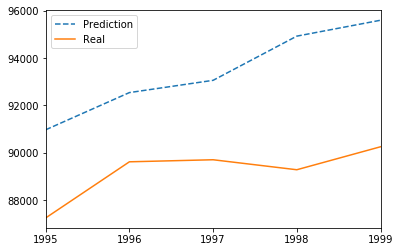

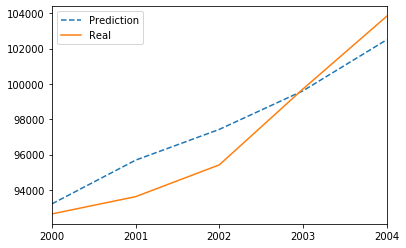

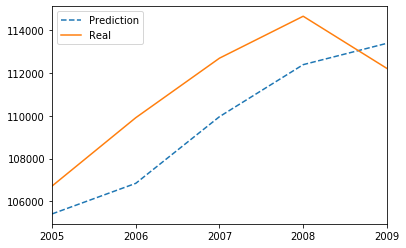

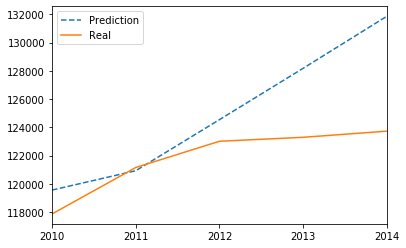

In [29]:
mape = []
for i in range(len(time_series_training)):
    y_pred = predictor.predict(ts=time_series_training[i], quantiles=[0.10, 0.5, 0.90])
    y_true = time_series[i].iloc[-5:]

    y_pred['0.5'].plot(ls='--', label='Prediction')
    y_true.plot(label='Real')
    plt.legend()
    plt.savefig('img/test_{}.png'.format(i))
    plt.show()
    
    mape.append(np.mean(np.abs(y_true.values - y_pred['0.5'].values) / y_true.values) * 100)

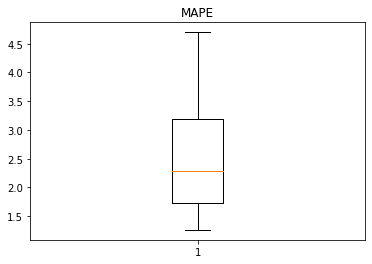

MAPE: 2.29


In [30]:
plt.boxplot(mape)
plt.title('MAPE')
plt.savefig('img/mape.png')
plt.show()

print('MAPE:', round(np.median(mape), 2))

In [31]:
# predictions
y_pred = predictor.predict(ts=ts.co2, quantiles=[0.10, 0.5, 0.90])
y_pred = y_pred.rename(columns={'0.9': 'Prediction'})
y_pred 

,0.1,Prediction,0.5
2020-12-31,122429.109375,141921.359375,132076.312500
2021-12-31,123865.843750,143472.203125,133392.250000
2022-12-31,128492.687500,150618.406250,137946.156250
2023-12-31,123744.898438,157388.984375,139159.734375
2024-12-31,124980.335938,157654.203125,143928.046875


# Deploy predictions

In [32]:
# data for visualization
ts_slice = ts['1850':].rename(columns={'co2': 'CO2 emissions'})

viz = ts_slice.merge(y_pred[['Prediction']], how='outer', left_index=True, right_index=True)
viz = viz.reset_index().rename(columns={'index': 'Year'})
viz.iloc[-5, 1] = viz.iloc[-5].Prediction
viz

,Year,CO2 emissions,Prediction
0,1850-12-31,944.824000,NaN
1,1851-12-31,944.689000,NaN
2,1852-12-31,984.086000,NaN
3,1853-12-31,1025.620000,NaN
4,1854-12-31,1209.253000,NaN
...,...,...,...
170,2020-12-31,141921.359375,141921.359375
171,2021-12-31,NaN,143472.203125
172,2022-12-31,NaN,150618.406250
173,2023-12-31,NaN,157388.984375


In [33]:
# plotly dashboard html file
fig = px.line(viz, x='Year', y=viz.columns, title='Global carbon dioxide emission prediction - MAPE: {}%'.format(round(np.median(mape), 2)))

fig.update_xaxes(
    tickformat='%Y', 
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=30, label='30 years', step='year', stepmode='backward'),
            dict(step='all')
        ])
    )
)

fig.write_html('website/file.html')

Link: http://capstone-deploy.s3-website-sa-east-1.amazonaws.com/

In [41]:
predictor.delete_endpoint()